[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HURU-School/HURUAI/blob/main/Lesson%202/First%20Model%20Breakdown.ipynb)

# Breaking Down Our First Model
Previously, we just ran through our first model and got to see the process involved in developing a deep learning model. Some parts might seem easy to understand, some parts not so much. In this section, we will break down each and every part of the code and really just dive deep into the inner workings of the model and how we built it from end to end. We will keep the structure we had earlier so that it is easy for us to follow along and compare what we are doing here to what we did earlier when training our first model. Let's Go!!!

## Fashion MNIST
Let's make it even more interesting. Let's switch and use a different dataset this time round. We will use the _Fashion Mnist_ dataset provided by torchvision, pytorch's machine vision library. Like MNIST, this dataset contains grayscale images, of sizes 28 * 28 pixels, of ten clothing types ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle Boot'). The image below shows a representation of the dataset.
![Fashion_Mnist](../images/Lesson_2/fashion-mnist.png)  

### Setting Up Our Development Enironment

#### Mounting Colab to Gdrive

In [ ]:
#  Mounts Google Colab on Gdrive.
from google.colab import drive
drive.mount('/content/gdrive')

#### Move to our Working Directory

In [ ]:
%cd /content/gdrive/My Drive/HuruAI

#### Notebook Setup

In [2]:
# The code below sets us up with some nice formatting for our plots.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Import the required packages

import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

#### Define a plot funtion that takes an image and returns it's predicted Class.
This part is usually not included here. It can be written on a separate page and imported. But I will leave it here so that we do not have to deal with the complexities.

In [21]:
def image_preds(image, probs):
    ''' This function is for viewing an image and its predicted class.
    '''
    probs = probs.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Returned Class Probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

### Preparing the Dataset

#### Defining Our Transforms
Transforms are a way to add variety to our data. Common transforms include:
  * Centre Crop - Crops a given image at the centre.
  * Color Jitter - randomly changing the brightness, hue, saturation or contrast in an image.
  * Grayscale - Converts a color image to grascale
  * Random Horizontal Flip - Horizontally flips random images in  a dataset
  
There are more transforms than these. You can read more about these transforms and what they do from the torchvision transforms documentation. In addition, we convert the images in our dataset into tensor datatypes and normalize the data as well. Color in a computer is represented as an integer with values between 0 - 255. Normalizing the tensors scales the values thus the model train faster. In the Normalize function, we pass the mean and standard deviation the function will use to normalize the data. In this case, we pass (0.5, 0.5)
$$
image = (image-mean) / std
$$
This normalizes the image to a range of [-1, 1].

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

#### Downloading the Dataset
We then download the dataset and apply the transfomations defined above. Data loaders provide a convenient way to load our datasets. They match each image to its label,  batch the data into the defined batch sizes and shuffle the data everytime the we are going through the dataloader, to reduce bias. Samplers can also be defined here if the dataset is imbalanced.

In [5]:
# Download and load the training data
trainset = datasets.FashionMNIST('./Data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('./Data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

#### Prepare an iterator
We prepare an iterator that will allow us to loop through our data loader, each time picking an image with its corresponding label as shown below
```python
for image, label in trainloader:
    ## What to do with the image and label.
```

In [6]:
train_iterator = iter(trainloader)
images, labels = train_iterator.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


We can then print out an image from the data loader as below

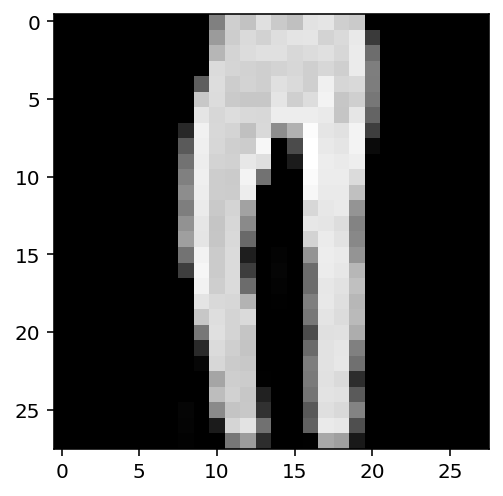

In [7]:
plt.imshow(images[9].numpy().squeeze(), cmap='Greys_r');

### Building Our Network
The network we implemented in our first model is called a _fully connected_ or _dense network_. In this network, each unit in a layer is connected to every other unit in the next layer. The input to this network MUST be a 1-D tensor. Since our images are 2-D tensors i.e (28 * 28 pixels), we need to convert them to 1-D tensors. This process is called _flattening._ We convert the shape from (64, 1, 28, 28) to (64, 784).
Similar to the network before, we need 10 output units, one for each class of clothing item we would like to predict. We calculate the probability that the image provided is of any one class or clothing defined in our labels. This is known as a _discrete probability distribution calculated over the classes(clothing) telling us the most likely class.

#### The Network Architecture

Our network consists of an input layer, two hidden layers and an output layer. Typically, the network will need to be _deeper_ than this, but we are keeping things simple. Our network will look as below.
![Network architecture](../images/Lesson_2/nn.png)  

#### Building Our Network Purely from Tensors
In this section we will explore building the network purely from weight matrices. Next, we will explore using torch's nn module to build the network. 

##### Define our activation function
In the first network, we used a ReLU activation function. For this we will switch things up an explore a new activation function, _the sigmoid activation function_. Mathematically, it is expressed as below:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$
Graphically, the function is represented as below.
![Sigmoid Function](../images/Lesson_2/sigmoid.PNG)  

In [8]:
## Initialize the sigmoid activation function.

def activation(x):
    return 1/(1+torch.exp(-x))


##### Flatten the Input Images

In [9]:
# Flatten the input images
inputs = images.view(images.shape[0], -1)

##### Randomly Initialize Our Weights and Bias

In [11]:
# Initializing Weights and Bias
w1 = torch.randn(784, 256)
b1 = torch.randn(256)

w2 = torch.randn(256, 64)
b2 = torch.randn(64)

w3 = torch.randn(64, 10)
b3 = torch.randn(10)

h1 = activation(torch.mm(inputs, w1) + b1)

h2 = activation(torch.mm(h1, w2) + b2)

out = torch.mm(h2, w3) + b3

##### Calculate Probability Distribution
The probability distribution is calculated by applying a _softmax function_ across the 10 classes. Mathematically, this function is represented as below:
$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^K{e^{x_k}}}
$$
It mashes each input x into a range between 0 and 1, then normalizes the values resulting in a proper distribution with the values all adding up to one.

In [13]:
## Define the softmax function

def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(out)

# Confirm that indeed the shape is (64, 10)
print(probabilities.shape)
# Confirm that the probabilirs all add up to 1
print(probabilities.sum(dim=1))

torch.Size([64, 10])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


#### Building the Network with Pytorch's _nn_ Module
Torch provides a handy module called _nn_, that makes building neural networks from scratch pretty easy.
First we inherit from the _nn.Module_ class, combine this with *super().__init__* function, will create a python class object with some useful methods and attributes. 

```python
self.hidden = nn.Linear(784, 256)
```
The line above will create a module for a linear transformation $x\mathbf{W} + b$, with 784 units as input and 256 units as output. Hidden layer 1 to hidden layer 2's transformation follows a similar approach with 256 units as input and 64 unts as output, as does the output layer, with 64 inputs and 10 outputs. 
Next we define the sigmoid activation function and the softmax output function. Setting (dim=1) calculates the softmax output across the columns only.
The nn module requires a forward function. The function takes an input tensor and passes it through the transformations defines in the *__init__ function*.  
**Note:** Order is not particularly important in the *__init__* definition but it is crucial in the forward method.

In [14]:
# Instantiate the Network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer 1 linear transformation
        self.hidden1 = nn.Linear(784, 256)
        # Hidden Layer 1 to hidden layer 2 linear transformation
        self.hidden2 = nn.Linear(256, 64)
        # Output layer, 10 units - one for each item of clothing
        self.output = nn.Linear(64, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x)
        x = self.sigmoid(x)
        x = self.hidden2(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [15]:
# Initialize the network

model = Net()
model

Net(
  (hidden1): Linear(in_features=784, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

#### Building the network using Pytorch's *nn.functional* Module
This module provides a more concise way to build the network architecture. This is by far the most common way to build network architectures in pytorch.

In [16]:
# Instantiate the network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer 1 linear transformation
        self.hidden1 = nn.Linear(784, 256)
        # Hidden Layer 1 to hidden layer 2 linear transformation
        self.hidden2 = nn.Linear(256, 64)
        # Output layer, 10 units - one for each item of clothing
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        # Hidden layer 1 with sigmoid activation
        x = F.sigmoid(self.hidden1(x))
        # Hidden layer 2 with sigmoid activation
        x = F.sigmoid(self.hidden2(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

##### Weights and Bias Initialization
The weights and biases are initialized, from a random distribution function, for you automatically, unlike when we were building purely from tensors. 

In [18]:
# Check the weights and biases initialized

print(model.hidden1.weight)
print(model.hidden1.bias)

Parameter containing:
tensor([[ 0.0247, -0.0240,  0.0190,  ...,  0.0107, -0.0271,  0.0138],
        [-0.0150,  0.0071, -0.0286,  ..., -0.0297, -0.0353, -0.0052],
        [-0.0323, -0.0269,  0.0026,  ...,  0.0091, -0.0200, -0.0129],
        ...,
        [ 0.0068, -0.0342, -0.0270,  ...,  0.0248, -0.0033, -0.0306],
        [ 0.0180,  0.0069,  0.0276,  ..., -0.0011, -0.0120,  0.0215],
        [ 0.0112,  0.0263,  0.0006,  ..., -0.0339, -0.0052, -0.0257]],
       requires_grad=True)
Parameter containing:
tensor([-1.2504e-02,  1.5813e-02,  3.3688e-02, -5.3383e-04,  2.6504e-02,
         3.4799e-02, -7.8687e-04, -1.9121e-02, -2.7735e-02, -1.1293e-02,
         3.0996e-02, -3.3681e-02,  5.4446e-04, -7.1977e-03, -2.9615e-02,
         1.4666e-02, -2.1334e-02, -3.4312e-02, -3.2713e-02,  1.2953e-02,
         3.1217e-03, -2.2046e-02, -3.8613e-03,  2.6329e-02,  2.9323e-02,
         3.1728e-02,  2.3292e-02, -1.0869e-02, -2.0499e-03,  1.1352e-02,
         2.4925e-03, -3.2473e-03,  6.3959e-03, -1.3545e-0

We could also customize how our weights and biases are initialized as shown below

###### Initializing using a constant value

In [19]:
# Fill all the bias values with zero
model.hidden1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

###### Initializing by sampling from a distibution function

In [20]:
# sample from random normal with standard dev = 0.03
model.hidden1.weight.data.normal_(std=0.03)

tensor([[-0.0532, -0.0340, -0.0284,  ..., -0.0281,  0.0217,  0.0509],
        [ 0.0020, -0.0219, -0.0150,  ...,  0.0210, -0.0224,  0.0101],
        [ 0.0092,  0.0211, -0.0058,  ..., -0.0621, -0.0397,  0.0457],
        ...,
        [-0.0311, -0.0290, -0.0078,  ...,  0.0081,  0.0198,  0.0224],
        [-0.0394, -0.0358, -0.0256,  ..., -0.0277,  0.0128, -0.0150],
        [ 0.0037, -0.0250, -0.0648,  ..., -0.0313, -0.0173,  0.0236]])

##### Making our forward pass through the Network.

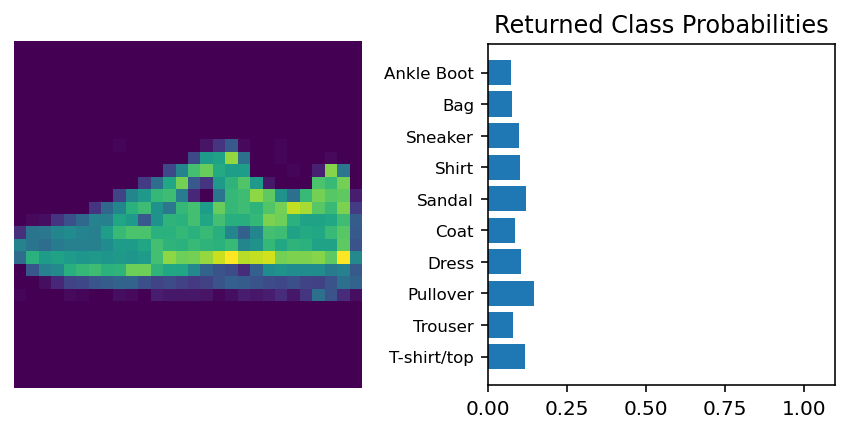

In [22]:
# Grab some data 
train_iterator = iter(trainloader)
images, labels = train_iterator.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
image_index = 0
probs = model.forward(images[image_index,:])

image = images[image_index]
image_preds(image.view(1, 28, 28), probs)

Our Network is not yet trained. As you can see in the plot above, it is just making random guesses. This is because we initialized the weights and biases from a random distribution, hence the random predictions.

#### Building the Network using the nn.Sequential Module

The nn.Sequential module is unique in that the input tensor is passed sequentially through the transformations. 

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


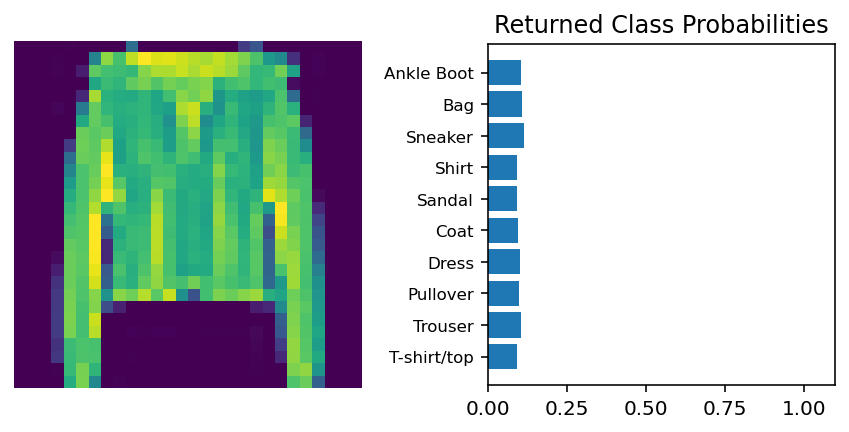

In [24]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [256, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
probs = model.forward(images[0,:])
image_preds(images[0].view(1, 28, 28), probs)

### Training the Network.

### Testing the Network

### Deployment.